This is Stock Price prediction part of project using Linear Regression 

In [68]:
import pandas as pd
import numpy as np

1. Select and preprocess stock data

In [171]:
data =  pd.read_csv('/Users/niweichong/Desktop/Git/Tools-Project-Data-Cleaning-master/Tools-Project-Data-Cleaning/Clean_Data_Out.csv')

#select values needed and particular stock, modify the date to trading days
def select_stock(stock_name:str):
    data_col_chosen = data[['Name','open','close','volume',]]
    data_stock_chosen = data_col_chosen.loc[data['Name']==stock_name]
    data_stock_chosen.insert(1, 'trading day', [i+1 for i in range(len(data_stock_chosen['Name']))])
    return data_stock_chosen

#eg. choose 'AAL'
data = select_stock('ABC')
data

,Name,trading day,open,close,volume
5036,ABC,1,46.52,46.89,1232802
5037,ABC,2,46.85,46.76,1115888
5038,ABC,3,46.70,46.96,1318773
5039,ABC,4,46.74,46.64,2645247
5040,ABC,5,46.67,46.77,1941879
5041,ABC,6,46.77,46.60,2962354
5042,ABC,7,46.67,47.22,1831692
5043,ABC,8,47.22,46.61,1970391
5044,ABC,9,46.48,46.48,1432331
5045,ABC,10,46.48,46.95,1003693


In [172]:
#output to csv file
data.to_csv('%s_preprocessed.csv' %data.iat[0, 0],index= False)

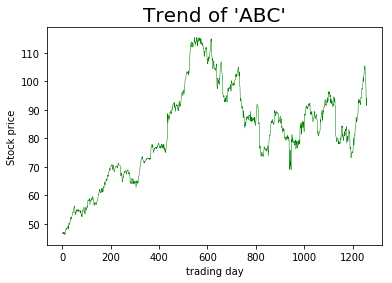

<Figure size 864x1152 with 0 Axes>

In [173]:
import matplotlib.pyplot as plt 

def plot(data):
    
    x=data["trading day"]
    y=data["close"]
    plt.xlabel('trading day')
    plt.ylabel('Stock price')
    
    plt.plot(x, y, '-',linewidth = 0.5, color = 'green' )
  
    # Set title
    plt.title("Trend of '%s'" %(data.iat[0, 0]), fontsize = 20)
    #Output a png file
    plt.savefig('stock_trend_fig_example.png', dpi = 600)
    
    plt.figure(figsize=(12,16))
    return plt.show()

plot(data)

In [155]:
import math
from IPython.display import display
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
import importlib

2. Prepare functions for training and testing

In [174]:
"""
    This function rescales a numpy array from input to target range
    x: data to scale
    input_range: optional input range for data, default 0.0:1.0
    target_range: optional target range for data, default 0.0:1.0
    return: rescaled array, incoming range [min,max]
"""
def scale_range(x, input_range, target_range):

    range = [np.amin(x), np.amax(x)]
    x_std = (x - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    x_scaled = x_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]

    return x_scaled, range

"""
    This function splits the data set into training and testing feature for Linear Regression Model
    stock: whole data set containing ['Open','Close','Volume'] features
    return: X_train : training sets of feature
            X_test : test sets of feature
            y_train: training sets of label
            y_test: test sets of label
            label_range: scaled range of label used in predicting price,
"""
    
def train_test_split_linear_regression(stock):
   
    # Create numpy arrays for features and targets
    feature = []
    label = []

    # Convert dataframe columns to numpy arrays for scikit learn
    for index, row in stock.iterrows():
        # print([np.array(row['trading day'])])
        feature.append([(row['trading day'])])
        label.append([(row['close'])])

    # Regularize the feature and target arrays and store min/max of input data for rescaling later
    feature_bounds = [min(feature), max(feature)]
    feature_bounds = [feature_bounds[0][0], feature_bounds[1][0]]
    label_bounds = [min(label), max(label)]
    label_bounds = [label_bounds[0][0], label_bounds[1][0]]

    feature_scaled, feature_range = scale_range(np.array(feature), input_range=feature_bounds, target_range=[-1.0, 1.0])
    label_scaled, label_range = scale_range(np.array(label), input_range=label_bounds, target_range=[-1.0, 1.0])

    # Define Test/Train Split 80/20
    split = .315
    split = int(math.floor(len(stock['trading day']) * split))

    # Set up training and test sets
    X_train = feature_scaled[:-split]
    X_test = feature_scaled[-split:]

    y_train = label_scaled[:-split]
    y_test = label_scaled[-split:]

    return X_train, X_test, y_train, y_test, label_range



In [177]:
#Load preprocessed data
stock = pd.read_csv('%s_preprocessed.csv' %data.iat[0, 0])
display(stock.head())

,Name,trading day,open,close,volume
0,ABC,1,46.52,46.89,1232802
1,ABC,2,46.85,46.76,1115888
2,ABC,3,46.70,46.96,1318773
3,ABC,4,46.74,46.64,2645247
4,ABC,5,46.67,46.77,1941879


In [179]:
#Split data into train and test pair
X_train, X_test, y_train, y_test, label_range= train_test_split_linear_regression(stock)

print("x_train", X_train.shape)
print("y_train", y_train.shape)
print("x_test", X_test.shape)
print("y_test", y_test.shape)


x_train (863, 1)
y_train (863, 1)
x_test (396, 1)
y_test (396, 1)


3. Train a Linear regressor model on training set and get prediction

In [180]:
"""
    This function builds a linear regression model using sklearn.linear_model
    X: Feature dataset
    y: label dataset
    return: a linear regression model
    """
def build_model(X, y):
    
    linear_mod = linear_model.LinearRegression()  # defining the linear regression model
    X = np.reshape(X, (X.shape[0], 1))
    y = np.reshape(y, (y.shape[0], 1))
    linear_mod.fit(X, y)  # fitting the data points in the model

    return linear_mod

In [181]:
model = build_model(X_train,y_train)

4. Get prediction on test set

In [164]:
###test
x = X_test
x = np.reshape(x, (x.shape[0], 1))
predicted_price = model.predict(x)
scale_range(predicted_price, input_range=[-1.0, 1.0], target_range=[-1, 1])

(array([[0.10397276],
        [0.10506141],
        [0.10615005],
        [0.1072387 ],
        [0.10832735],
        [0.10941599],
        [0.11050464],
        [0.11159328],
        [0.11268193],
        [0.11377058],
        [0.11485922],
        [0.11594787],
        [0.11703651],
        [0.11812516],
        [0.11921381],
        [0.12030245],
        [0.1213911 ],
        [0.12247974],
        [0.12356839],
        [0.12465704],
        [0.12574568],
        [0.12683433],
        [0.12792297],
        [0.12901162],
        [0.13010027],
        [0.13118891],
        [0.13227756],
        [0.1333662 ],
        [0.13445485],
        [0.13554349],
        [0.13663214],
        [0.13772079],
        [0.13880943],
        [0.13989808],
        [0.14098672],
        [0.14207537],
        [0.14316402],
        [0.14425266],
        [0.14534131],
        [0.14642995],
        [0.1475186 ],
        [0.14860725],
        [0.14969589],
        [0.15078454],
        [0.15187318],
        [0

In [182]:
"""
    This function predicts the label for given test sets
    model: a linear regression model
    x: testing features
    label_range: normalised range of label data
    return: predicted labels for given features
    """
def predict_prices(model, x, label_range):
    
    x = np.reshape(x, (x.shape[0], 1))
    predicted_price = model.predict(x)
    predictions_rescaled, re_range = scale_range(predicted_price, input_range=[-1.0, 1.0], target_range=[-0.5, 0.5])

    return predictions_rescaled.flatten()

prediction = predict_prices(model,X_test, label_range)
prediction

array([0.35680992, 0.3576486 , 0.35848728, 0.35932597, 0.36016465,
       0.36100333, 0.36184202, 0.3626807 , 0.36351939, 0.36435807,
       0.36519675, 0.36603544, 0.36687412, 0.3677128 , 0.36855149,
       0.36939017, 0.37022885, 0.37106754, 0.37190622, 0.37274491,
       0.37358359, 0.37442227, 0.37526096, 0.37609964, 0.37693832,
       0.37777701, 0.37861569, 0.37945438, 0.38029306, 0.38113174,
       0.38197043, 0.38280911, 0.38364779, 0.38448648, 0.38532516,
       0.38616385, 0.38700253, 0.38784121, 0.3886799 , 0.38951858,
       0.39035726, 0.39119595, 0.39203463, 0.39287332, 0.393712  ,
       0.39455068, 0.39538937, 0.39622805, 0.39706673, 0.39790542,
       0.3987441 , 0.39958279, 0.40042147, 0.40126015, 0.40209884,
       0.40293752, 0.4037762 , 0.40461489, 0.40545357, 0.40629226,
       0.40713094, 0.40796962, 0.40880831, 0.40964699, 0.41048567,
       0.41132436, 0.41216304, 0.41300173, 0.41384041, 0.41467909,
       0.41551778, 0.41635646, 0.41719514, 0.41803383, 0.41887

5. Plot the predicted values against actual

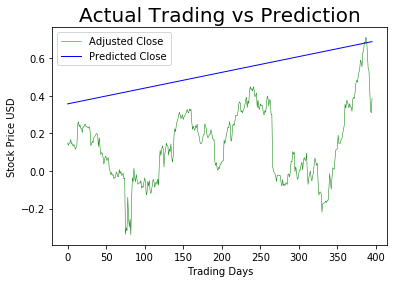

In [184]:
"""
    This function plots train, test and prediction
    actual: DataFrame containing actual data
    prediction: DataFrame containing predicted values
    title:  Title of the plot
    y_label: yLabel of the plot
    x_label: xLabel of the plot
    return: prints a Pyplot against trading days and their close price value
    """
def plot_prediction(actual, prediction, title='Actual Trading vs Prediction', y_label='Stock Price USD', x_label='Trading Days'):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.ylabel(y_label)
    plt.xlabel(x_label)

    # Plot actual and predicted close values
    plt.plot(actual, lw=0.5, color='green', label='Adjusted Close')
    plt.plot(prediction, lw=1, color='blue', label='Predicted Close')

    # Set title
    ax.set_title(title, size=20)
    ax.legend(loc='upper left')

    plt.show()

plot_prediction(y_test,prediction)


# plt.plot(y_test,lw=0.5,label="Adjusted actual close",color='green')
# plt.plot(prediction,lw=1,label="Predicted close",color='blue')
# plt.plot(y_test,'-')
# plt.title("Linear Regression Prediction",size=20)
# plt.xlabel('trading day',size=12)
# plt.ylabel('Stock Price USD',size=12)
# ax.legend(loc='upper left')
